<a href="https://colab.research.google.com/github/Jonkkeyler333/preciCol/blob/main/notebooks/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analisis Exploratorio de Datos (EDA)**

## Librerías necesarias

In [87]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit ,to_timestamp, dayofmonth, month, year
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from statsmodels.tsa.seasonal import seasonal_decompose

In [88]:
##OJO ESTO SOLO ES PARA USAR DRIVE , SE DEBE QUITAR
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocesamiento Inicial

In [89]:
def preprocesar_ciudad(city):
    try:
        path = f'./drive/MyDrive/data_project/enriched/{city}'
        df = spark.read.parquet(path)
        print(f'\n>>> Resumen del DataFrame original para {city}:\n')
        df.show(5)

        df = df.withColumn("dia", dayofmonth(col("time")))
        df = df.withColumn("mes", month(col("time")))
        df = df.withColumn("año", year(col("time")))
        df = df.dropna()

        print(f'\n>>> Esquema actualizado para {city} después del preprocesamiento:\n')
        df.printSchema()

        df = df.toPandas()
        df.set_index('time', inplace=True)
        return df
    except Exception as e:
        print(f"Error procesando la ciudad {city}: {e}")
        return None

In [90]:
#@title Inicializacion del Spark Context
plt.style.use('ggplot')
CITIES=['SOLEDAD','CARTAGENA DE INDIAS','VALLEDUPAR','BOGOTA D.C','NEIVA','RIOHACHA','PASTO','CÚCUTA','ARMENIA','SAN ANDRÉS']
spark = SparkSession.builder.appName('EDA').getOrCreate()

In [91]:
## Tener cuidado con sogamoso
path_sogamoso=f'./drive/MyDrive/data_project/enriched/SOGAMOSO'
df_original=spark.read.parquet(path_sogamoso)
df_pd=df_original.toPandas()
df_pd.set_index('fecha_observacion',inplace=True)
df_pd.plot(y='precipitacion')
plt.show()
del df_pd
del df_original

AnalysisException: [PATH_NOT_FOUND] Path does not exist: file:/content/drive/MyDrive/data_project/enriched/SOGAMOSO.

# Definicion de Funciones

In [92]:
def analizar_ciudad(df_preprocesado, mostrar_head=True, graficar=True):
    try:
        if 'precipitacion' in df_preprocesado.columns:
            if graficar:
                plt.figure(figsize=(10, 5))
                plt.plot(df_preprocesado.index, df_preprocesado['precipitacion'], label="Precipitacion")
                plt.xlabel('Fecha')
                plt.ylabel('Precipitación')
                plt.title(f'Precipitación en la ciudad')
                plt.legend()
                plt.tight_layout()
                plt.show()
        else:
            print(f'La ciudad procesada no tiene columnas "time" o "precipitacion".')

    except Exception as e:
        print(f"Error procesando la ciudad procesada: {e}")

In [93]:
def boxplot_mes_ciudad(df_preprocesado, mostrar_head=True, graficar=True):
    try:
        if  'precipitacion' in df_preprocesado.columns and 'mes' in df_preprocesado.columns:
            if graficar:
                plt.figure(figsize=(12, 6))
                sns.boxplot(x="mes", y="precipitacion", data=df_preprocesado)
                plt.yscale('log')
                plt.xlabel('Mes')
                plt.ylabel('Precipitación')
                plt.title(f'Box Plot de Precipitación por Mes en la ciudad procesada')
                plt.xticks(ticks=range(12), labels=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
                                                    'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
                plt.tight_layout()
                plt.show()
        else:
            print(f'La ciudad procesada no tiene las columnas necesarias: "time", "precipitacion" o "mes".')
    except Exception as e:
        print(f"Error procesando la ciudad procesada: {e}")

In [94]:
def estadisticas_precipitacion(df_preprocesado):
    try:
        if 'precipitacion' not in df_preprocesado.columns:
            print(f'La ciudad no tiene columnas "time" o "precipitacion".')
            return
        precip = df_preprocesado['precipitacion']

        media = precip.mean()
        mediana = precip.median()
        moda = precip.mode()
        minimo = precip.min()
        maximo = precip.max()
        fecha_min = precip.idxmin()
        fecha_max = precip.idxmax()

        # Mostrar como texto
        print(f"\n Estadísticas de precipitación:\n")
        print(f"• Media: {media:.2f}")
        print(f"• Mediana: {mediana:.2f}")
        print(f"• Moda: {moda.iloc[0] if not moda.empty else 'No disponible'}")
        print(f"• Mínimo: {minimo} el {fecha_min.strftime('%Y-%m-%d')}")
        print(f"• Máximo: {maximo} el {fecha_max.strftime('%Y-%m-%d')}\n")

    except Exception as e:
        print(f"⚠️ Error procesando el DataFrame: {e}")

In [95]:
def analisis_temporal(df):
    """
    Realiza análisis temporal de temperatura, humedad relativa,
    precipitación y velocidad del viento para una ciudad específica.
    Muestra gráficos individuales y uno combinado.
    """
    try:
        # Gráficas individuales
        variables = {
            'temp': 'Temperatura (°C)',
            'rhum': 'Humedad Relativa (%)',
            'precipitacion': 'Precipitación (mm)',
            'wspd': 'Velocidad del Viento (km/h)'
        }

        for var, etiqueta in variables.items():
            if var in df.columns:
                plt.figure(figsize=(10, 4))
                plt.plot(df.index, df[var], label=etiqueta, color='tab:blue')
                plt.title(f'{etiqueta} en la ciudad')
                plt.xlabel('Fecha')
                plt.ylabel(etiqueta)
                plt.grid(True)
                plt.tight_layout()
                plt.show()
            else:
                print(f' La columna "{var}" no existe en el dataset.')

    except Exception as e:
        print(f" Error procesando la ciudad {city}: {e}")

In [96]:
def correlaciones_ciudad(df, columnas):
    try:
        print(f"\n>>> Correlaciones entre columnas: {columnas}\n")
        columnas_validas = [col for col in columnas if col in df.columns]
        if not columnas_validas:
            print("Ninguna de las columnas proporcionadas existe en el DataFrame.")
            return

        matriz = df[columnas_validas].corr()

        plt.figure(figsize=(8, 6))
        sns.heatmap(matriz, annot=True, cmap='coolwarm', fmt=".2f", square=True)
        plt.title("Matriz de correlación")
        plt.tight_layout()
        plt.show()

        for col1, col2 in combinations(columnas_validas, 2):
            correlacion = matriz.loc[col1, col2]

            if correlacion >= 0.7:
                interpretacion = "Fuerte relación positiva"
            elif correlacion >= 0.5:
                interpretacion = "Relación moderada positiva"
            elif correlacion >= 0.3:
                interpretacion = "Relación débil positiva"
            elif correlacion > -0.3:
                interpretacion = "Relación insignificante"
            elif correlacion > -0.5:
                interpretacion = "Relación débil negativa"
            elif correlacion > -0.7:
                interpretacion = "Relación moderada negativa"
            else:
                interpretacion = "Fuerte relación negativa"

            print(f"• Correlación entre '{col1}' y '{col2}': {correlacion:.2f} → {interpretacion}.")

    except Exception as e:
        print(f"Error calculando correlaciones: {e}")

In [97]:
def descompose_time_series(data,period:int):
    decomposition=seasonal_decompose(data,model='additive',period=period)
    trend=decomposition.trend
    seasonal=decomposition.seasonal
    residual=decomposition.resid
    fig,ax=plt.subplots(4,1,figsize=(10,10))
    data.plot(ax=ax[0],title=f'Original {data.name}',color='black')
    trend.plot(ax=ax[1],title='Trend',color='Red')
    seasonal.plot(ax=ax[2],title='Seasonal',color='Green')
    residual.plot(ax=ax[3],title='Residual',color='Blue')
    plt.tight_layout()
    plt.show()
    return trend, seasonal, residual


>>> Resumen del DataFrame original para CARTAGENA DE INDIAS:

+-------------------+----+------------------+-----------------+----+------------------+------+----+-------------+
|               time|temp|              dwpt|             rhum|wdir|              wspd|  pres|coco|precipitacion|
+-------------------+----+------------------+-----------------+----+------------------+------+----+-------------+
|2024-01-01 00:00:00|28.0|              23.6|             78.0|20.0|              18.0|1011.0| 2.0|          0.0|
|2024-01-01 00:10:00|28.0|23.633333333333333|78.16666666666667|20.0|18.066666666666666|1011.0| 2.0|          0.0|
|2024-01-01 00:20:00|28.0|23.666666666666668|78.33333333333333|20.0|18.133333333333333|1011.0| 2.0|          0.0|
|2024-01-01 00:30:00|28.0|23.700000000000003|             78.5|20.0|              18.2|1011.0| 2.0|          0.0|
|2024-01-01 00:40:00|28.0|23.733333333333334|78.66666666666667|20.0|18.266666666666666|1011.0| 2.0|          0.0|
+-------------------+----

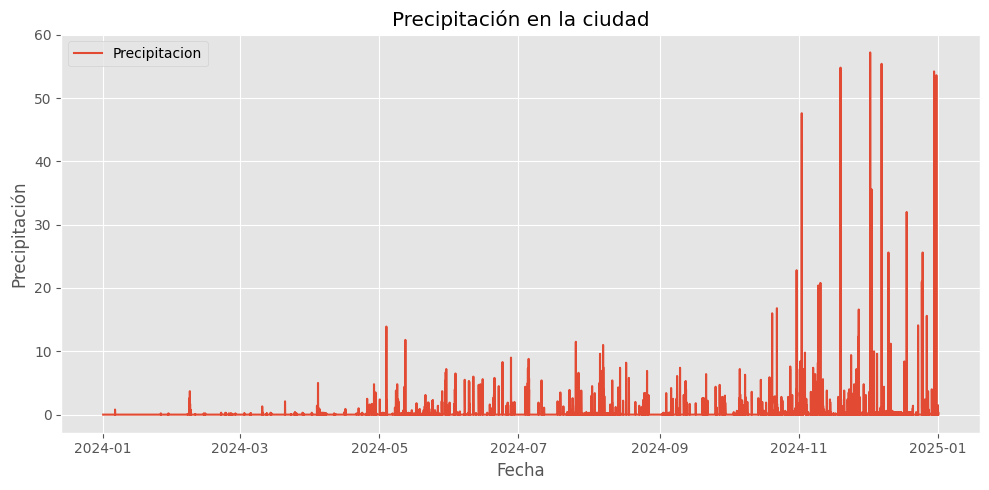

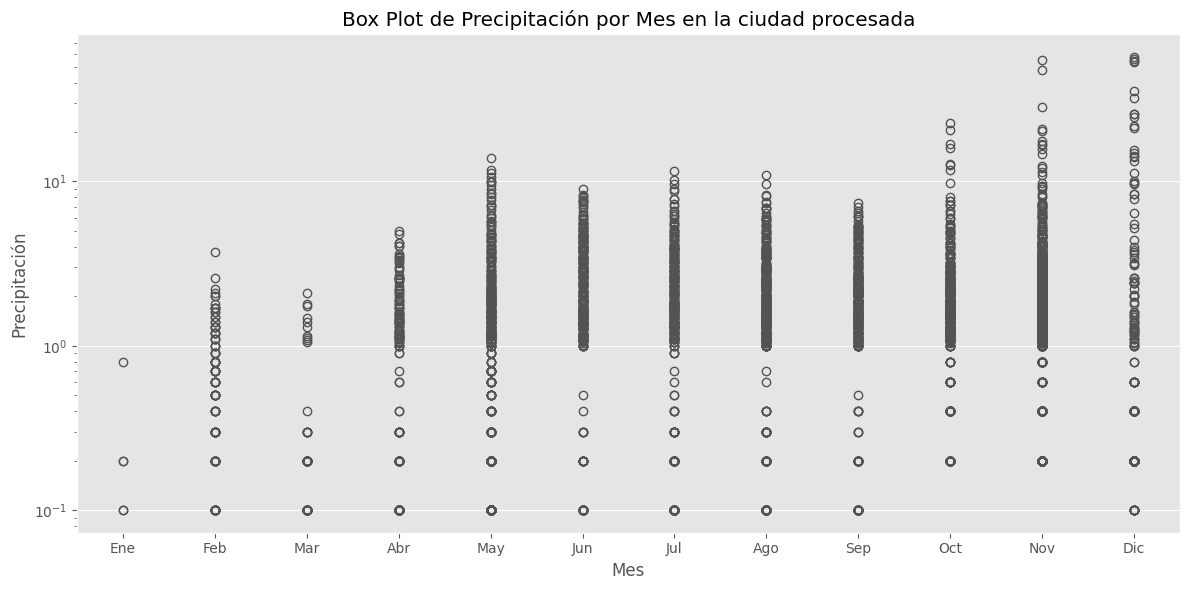


 Estadísticas de precipitación:

• Media: 0.14
• Mediana: 0.00
• Moda: 0.0
• Mínimo: 0.0 el 2024-01-01
• Máximo: 57.2 el 2024-12-02



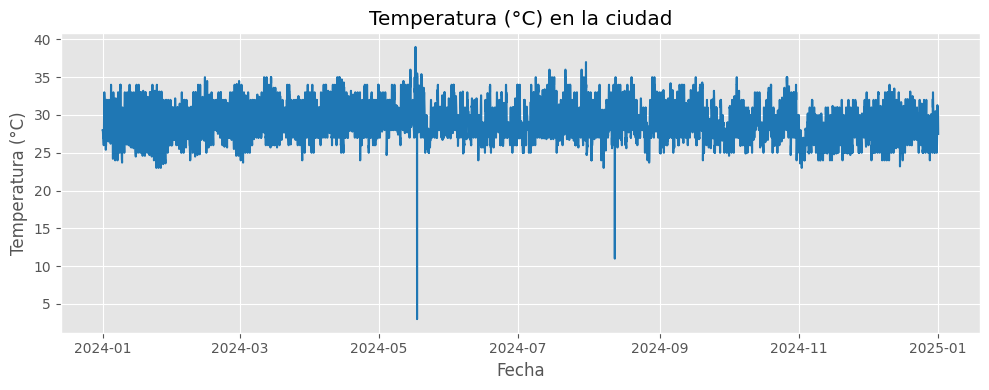

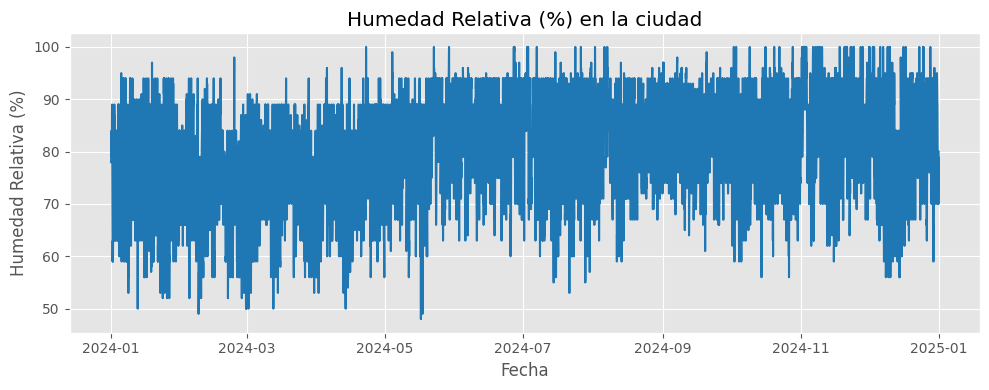

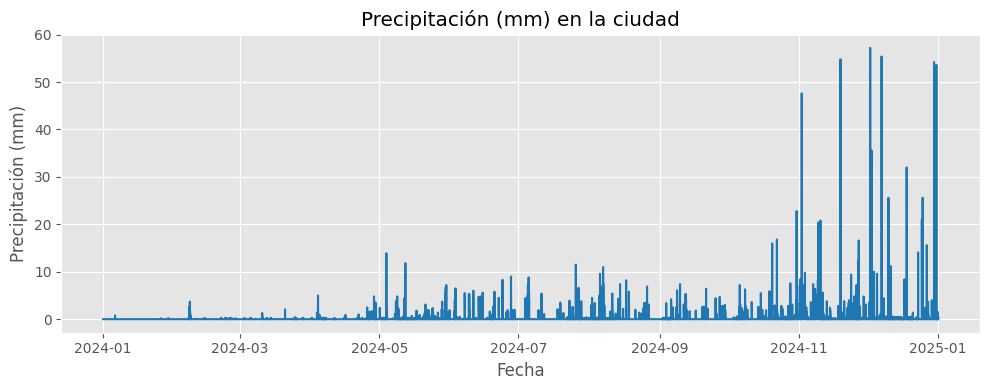

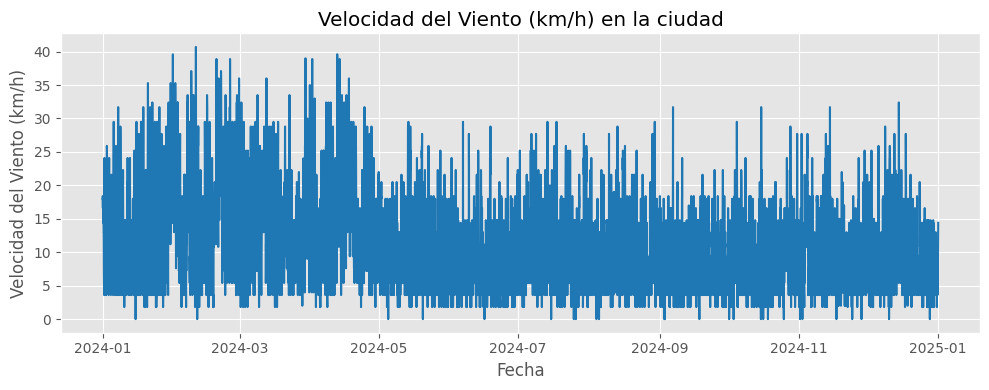


>>> Correlaciones entre columnas: ['temp', 'rhum', 'precipitacion', 'wspd']



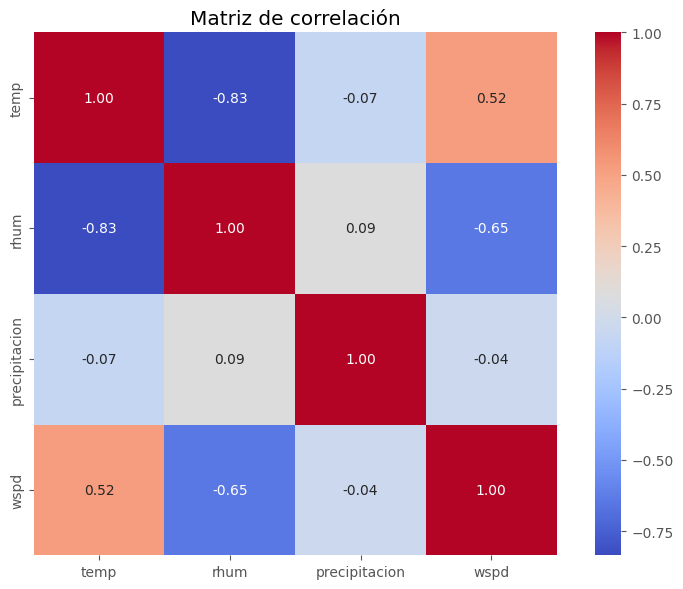

• Correlación entre 'temp' y 'rhum': -0.83 → Fuerte relación negativa.
• Correlación entre 'temp' y 'precipitacion': -0.07 → Relación insignificante.
• Correlación entre 'temp' y 'wspd': 0.52 → Relación moderada positiva.
• Correlación entre 'rhum' y 'precipitacion': 0.09 → Relación insignificante.
• Correlación entre 'rhum' y 'wspd': -0.65 → Relación moderada negativa.
• Correlación entre 'precipitacion' y 'wspd': -0.04 → Relación insignificante.


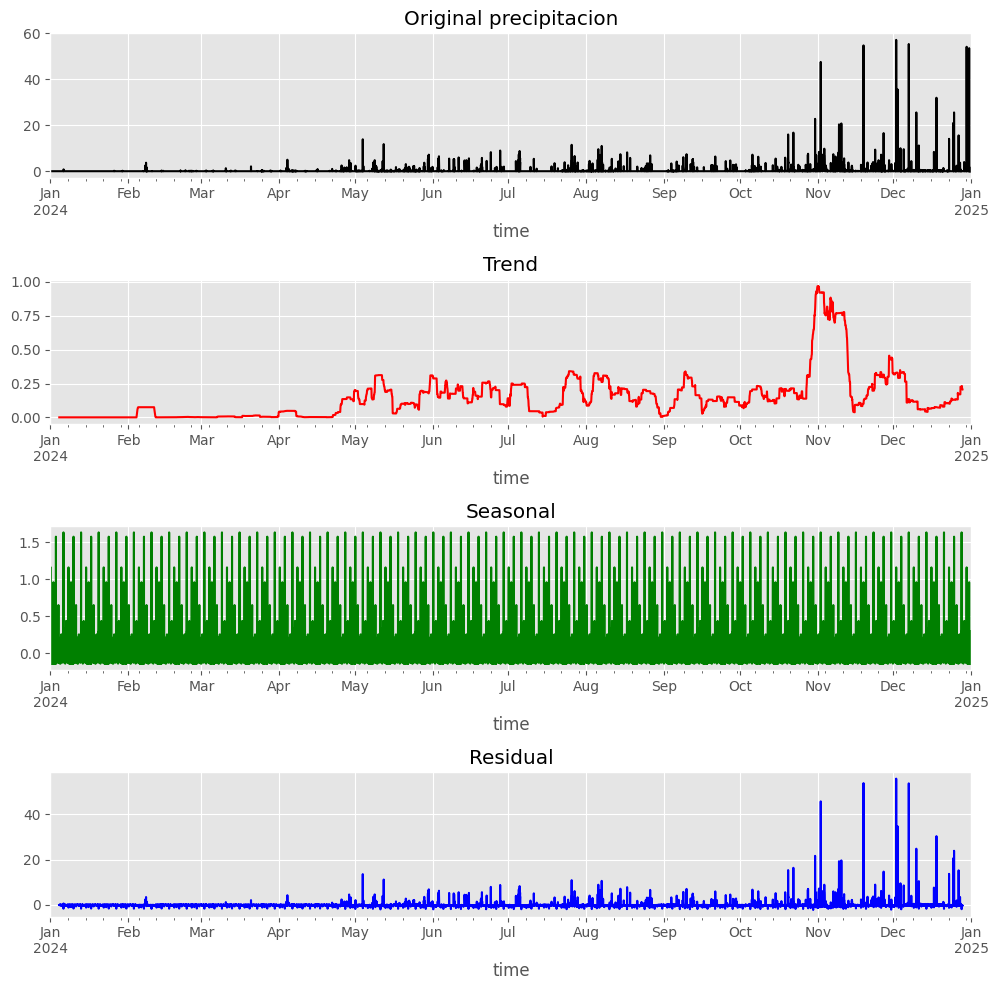

In [98]:
df_cartagena = preprocesar_ciudad('CARTAGENA DE INDIAS')
analizar_ciudad(df_cartagena)
boxplot_mes_ciudad(df_cartagena)
estadisticas_precipitacion(df_cartagena)
analisis_temporal(df_cartagena)
columnas_interes = ["temp", "rhum", "precipitacion", "wspd"]
correlaciones_ciudad(df_cartagena, columnas_interes)
trend1 , seasonal1, residual1 = descompose_time_series(df_cartagena['precipitacion'],1008)